## Analyzing Customer Demographic

In [1]:
# Start Spark Session
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "20g")
    .config("spark.executor.memory", "20g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/11 15:08:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Opening 'BNPL' dataset
merchants = spark.read.parquet("/Users/roseline/Documents/GitHub/generic-buy-now-pay-later-project-group-11/data/tables/tbl_merchants.parquet")
consumer = spark.read.csv("/Users/roseline/Documents/GitHub/generic-buy-now-pay-later-project-group-11/data/tables/tbl_consumer.csv", header=True, sep="|")
details = spark.read.parquet("/Users/roseline/Documents/GitHub/generic-buy-now-pay-later-project-group-11/data/tables/consumer_user_details.parquet")

In [3]:
# load all transactions datasets
paths=['/Users/roseline/Documents/GitHub/generic-buy-now-pay-later-project-group-11/data/tables/transactions_20210228_20210827_snapshot',
       '/Users/roseline/Documents/GitHub/generic-buy-now-pay-later-project-group-11/data/tables/transactions_20210828_20220227_snapshot']

first = 1
for path in paths:
    if first:
        transactions = spark.read.parquet(path)
        print(f'added {path.split("/")[3]}')
        first = 0
    else:
        append_transactions = spark.read.parquet(path)
        transactions = transactions.union(append_transactions)
        print(f'added {path.split("/")[3]}')

added Documents


added Documents


In [4]:
# rename columns
merchants = merchants.withColumnRenamed('name', 'merchant_name')
consumer = consumer.withColumnRenamed('name', 'consumer_name')

In [19]:
# Join consumers with their respective details
consumer_detail = consumer.join(details, on="consumer_id")

# Join consumers with their respective transactions
consumer_trx = consumer_detail.join(transactions, on="user_id")

# Join transactions with the respective merchants
df_trx = consumer_trx.join(merchants, on="merchant_abn")

---
### Customer gender proportion based on transactions data

In [6]:
# Importing relevant functions
from pyspark.sql import functions as F

In [7]:
# Find distinct values on the 'gender' column
consumer.select('gender').distinct().show()

+-----------+
|     gender|
+-----------+
|Undisclosed|
|     Female|
|       Male|
+-----------+



In [20]:
# Count the proportion on each of the distinct values in 'gender' (on percentage)
consumer_trx2 = consumer_trx.groupby('gender').count()
consumer_trx2

gender,count
Undisclosed,828354
Female,3623408
Male,3699610


In [21]:
# Count the proportion on each of the distinct values in 'gender' (on percentage)
total_consumer = consumer_trx.count()
female_proportion = (consumer_trx2.collect()[1][1] / total_consumer)*100
male_proportion = (consumer_trx2.collect()[2][1] / total_consumer)*100
undisclosed_proportion = (consumer_trx2.collect()[0][1] / total_consumer)*100

In [22]:
# Create new dataframe to store gender proportion data
from pyspark.sql.types import StructType, StructField, StringType

data2 = [('female', female_proportion), ('male', male_proportion), ('undisclosed', undisclosed_proportion)]

schema2 = StructType([\
    StructField('gender',StringType(),True), \
    StructField('gender_proportion',StringType(),True), \
        ])

gender_prop = spark.createDataFrame(data=data2,schema=schema2)
gender_prop.printSchema()
gender_prop.show(truncate=False)

root
 |-- gender: string (nullable = true)
 |-- gender_proportion: string (nullable = true)

+-----------+------------------+
|gender     |gender_proportion |
+-----------+------------------+
|female     |44.45151073954176 |
|male       |45.386347230871074|
|undisclosed|10.162142029587166|
+-----------+------------------+



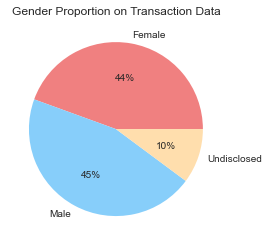

In [12]:
# Simple visualisations for gender proportion
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
import numpy as np

y = np.array([female_proportion, male_proportion, undisclosed_proportion])
mylabels = ['Female', 'Male', 'Undisclosed']

fig = plt.pie(y, labels = mylabels, colors = ['lightcoral', 'lightskyblue', 'navajowhite'], autopct='%1.0f%%')
plt.title('Gender Proportion on Transaction Data')
plt.savefig("pie_chart_gender.jpeg")
plt.show()

---
### Calculate proportion of merchants level

In [13]:
from pyspark.sql.functions import split

In [28]:
# Extracting the merchants level from 'tags' column
from pyspark.sql.functions import substring, length, col, expr
df_trx = df_trx.withColumn('temp_level',expr("substring(tags, 1, length(tags)-21)"))
df_trx = df_trx.withColumn('level', df_trx.temp_level.substr(-1,1))
df_trx.select('level').show(truncate=False)

+-----+
|level|
+-----+
|a    |
|a    |
|b    |
|c    |
|b    |
|c    |
|a    |
|b    |
|a    |
|c    |
|a    |
|b    |
|b    |
|a    |
|a    |
|a    |
|e    |
|d    |
|a    |
|a    |
+-----+
only showing top 20 rows



In [29]:
df_trx.select('level').distinct().show()

+-----+
|level|
+-----+
|    e|
|    d|
|    c|
|    b|
|    a|
+-----+



In [55]:
# Count the proportion on each of the distinct values in 'gender' (on percentage)
df_trx_count = df_trx.groupBy('level').count().sort('level')
df_trx_count

level,count
a,3509188
b,2251496
c,1909472
d,78521
e,69053


In [56]:
# Proportion of merchants per level
total_merchants = df_trx.count()
merchants_level_a = (df_trx_count.collect()[0][1] / total_merchants)*100
merchants_level_b = (df_trx_count.collect()[1][1] / total_merchants)*100
merchants_level_c = (df_trx_count.collect()[2][1] / total_merchants)*100
merchants_level_d = (df_trx_count.collect()[3][1] / total_merchants)*100
merchants_level_e = (df_trx_count.collect()[4][1] / total_merchants)*100

In [57]:
# Create new dataframe to store gender proportion data
from pyspark.sql.types import StructType, StructField, StringType

data3 = [('a', merchants_level_a), ('b', merchants_level_b), ('c', merchants_level_c), ('d', merchants_level_d), ('e', merchants_level_e)]

schema3 = StructType([\
    StructField('level',StringType(),True), \
    StructField('merchant_level_proportion',StringType(),True), \
        ])

merchant_proportion = spark.createDataFrame(data=data3,schema=schema3)
merchant_proportion.printSchema()
merchant_proportion.show(truncate=False)

root
 |-- level: string (nullable = true)
 |-- merchant_level_proportion: string (nullable = true)

+-----+-------------------------+
|level|merchant_level_proportion|
+-----+-------------------------+
|a    |44.88755687392632        |
|b    |28.79986901568614        |
|c    |24.42489060123591        |
|d    |1.0043964168626955       |
|e    |0.8832870922889381       |
+-----+-------------------------+



---
### Transaction Frequency (Monthly)

In [35]:
transactions.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



In [36]:
# Splitting the 'order_datetime' column based on year, month, and date
transactions = transactions.withColumn('year', split(transactions['order_datetime'], '-').getItem(0)) \
                           .withColumn('month', split(transactions['order_datetime'], '-').getItem(1)) \
                           .withColumn('date', split(transactions['order_datetime'], '-').getItem(2))
transactions.show(truncate=False)

+-------+------------+------------------+------------------------------------+--------------+----+-----+----+
|user_id|merchant_abn|dollar_value      |order_id                            |order_datetime|year|month|date|
+-------+------------+------------------+------------------------------------+--------------+----+-----+----+
|18478  |62191208634 |63.255848959735246|949a63c8-29f7-4ab0-ada4-99ac50a88952|2021-08-20    |2021|08   |20  |
|2      |15549624934 |130.3505283105634 |6a84c3cf-612a-4574-835b-144a47353eff|2021-08-20    |2021|08   |20  |
|18479  |64403598239 |120.15860593212783|b10dcc33-e53f-4254-863c-de5266810cbc|2021-08-20    |2021|08   |20  |
|3      |60956456424 |136.6785200286976 |0f09c5a5-784e-4477-b049-8ee4dd069b7b|2021-08-20    |2021|08   |20  |
|18479  |94493496784 |72.96316578355305 |f6c78c1a-4600-4c5f-8e97-6e9eb534b586|2021-08-20    |2021|08   |20  |
|3      |76819856970 |448.529684285612  |5ace6a24-cdf0-4aa3-b571-1d9406b352b5|2021-08-20    |2021|08   |20  |
|18479  |6

In [37]:
# Divide transactions according to year
tx_2021 = transactions.filter(transactions.year == '2021')
tx_2022 = transactions.filter(transactions.year == '2022')

In [38]:
# Find distinct month on both year '2021' and '2022'
tx_2021.select('month').distinct().show()
tx_2022.select('month').distinct().show()

+-----+
|month|
+-----+
|   07|
|   05|
|   08|
|   06|
|   04|
|   03|
|   02|
|   11|
|   12|
|   09|
|   10|
+-----+



+-----+
|month|
+-----+
|   01|
|   02|
+-----+



In [41]:
# Count transactions monthly for year '2021'
tx_2021_new = tx_2021.groupBy('month').count().sort('month')
tx_2021_new

month,count
02,17107
03,546333
04,560680
05,636666
06,627148
07,655279
08,688822
09,678524
10,729619
11,991226


In [43]:
# Count transactions monthly for year '2022'
tx_2022_new = tx_2022.groupBy('month').count().sort('month')
tx_2022_new

month,count
01,552478
02,509843


In [42]:
# Count transactions monthly for year '2021'
tx_02_2021 = tx_2021_new.collect()[0][1]
tx_03_2021 = tx_2021_new.collect()[1][1]
tx_04_2021 = tx_2021_new.collect()[2][1]
tx_05_2021 = tx_2021_new.collect()[3][1]
tx_06_2021 = tx_2021_new.collect()[4][1]
tx_07_2021 = tx_2021_new.collect()[5][1]
tx_08_2021 = tx_2021_new.collect()[6][1]
tx_09_2021 = tx_2021_new.collect()[7][1]
tx_10_2021 = tx_2021_new.collect()[8][1]
tx_11_2021 = tx_2021_new.collect()[9][1]
tx_12_2021 = tx_2021_new.collect()[10][1]

In [44]:
# Count transactions monthly for year '2022'
tx_01_2022 = tx_2022_new.collect()[0][1]
tx_02_2022 = tx_2022_new.collect()[1][1]

In [45]:
# Create new dataframe to store transaction frequency data
from pyspark.sql.types import StructType, StructField, StringType

data = [('2021', '02', tx_02_2021), ('2021', '03', tx_03_2021), ('2021', '04', tx_04_2021), ('2021', '05', tx_05_2021),
        ('2021', '06', tx_06_2021), ('2021', '07', tx_07_2021), ('2021', '08', tx_08_2021), ('2021', '09', tx_09_2021),
        ('2021', '10', tx_10_2021), ('2021', '11', tx_11_2021), ('2021', '12', tx_12_2021), ('2022', '01', tx_01_2022),
        ('2022', '02', tx_02_2022)]

schema = StructType([\
    StructField('year',StringType(),True), \
    StructField('month',StringType(),True), \
    StructField('transaction_frequency',StringType(),True), \
        ])

tx_frequency = spark.createDataFrame(data=data,schema=schema)
tx_frequency.printSchema()
tx_frequency.show(truncate=False)

root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- transaction_frequency: string (nullable = true)

+----+-----+---------------------+
|year|month|transaction_frequency|
+----+-----+---------------------+
|2021|02   |17107                |
|2021|03   |546333               |
|2021|04   |560680               |
|2021|05   |636666               |
|2021|06   |627148               |
|2021|07   |655279               |
|2021|08   |688822               |
|2021|09   |678524               |
|2021|10   |729619               |
|2021|11   |991226               |
|2021|12   |957647               |
|2022|01   |552478               |
|2022|02   |509843               |
+----+-----+---------------------+



---
### Counting the number of unique customers

In [46]:
consumer_trx.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



In [47]:
# Splitting the 'order_datetime' column based on year, month, and date
consumer_trx = consumer_trx.withColumn('year', split(consumer_trx['order_datetime'], '-').getItem(0)) \
                           .withColumn('month', split(consumer_trx['order_datetime'], '-').getItem(1)) \
                           .withColumn('date', split(consumer_trx['order_datetime'], '-').getItem(2))

In [48]:
# Divide transactions according to year
consumer_trx_2021 = consumer_trx.filter(consumer_trx.year == '2021')
consumer_trx_2022 = consumer_trx.filter(consumer_trx.year == '2022')

In [49]:
# Calculating the number of unique customers in year '2021' and '2022'
from pyspark.sql.functions import countDistinct

consumer_trx_2021.select(countDistinct('merchant_abn')).show()
consumer_trx_2022.select(countDistinct('merchant_abn')).show()

+----------------------------+
|count(DISTINCT merchant_abn)|
+----------------------------+
|                        4406|
+----------------------------+



+----------------------------+
|count(DISTINCT merchant_abn)|
+----------------------------+
|                        4166|
+----------------------------+



---
### Calculate average transaction amount per merchant 

In [50]:
df_trx.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- temp_level: string (nullable = true)
 |-- level: string (nullable = true)



In [58]:
# Transaction per merchant
df_trx_new = df_trx.groupBy('level').agg({'dollar_value': 'sum'}).sort('level')
df_trx_new

level,sum(dollar_value)
a,4.992719890010322E8
b,4.440593165425465E8
c,2.6056001034780312E8
d,2.1559245778400015E7
e,1.4246462010845559E7


In [59]:
# Average transaction per merchant
avg_trx_a = (df_trx_new.collect()[0][1] / df_trx_count.collect()[0][1])
avg_trx_b = (df_trx_new.collect()[1][1] / df_trx_count.collect()[1][1])
avg_trx_c = (df_trx_new.collect()[2][1] / df_trx_count.collect()[2][1])
avg_trx_d = (df_trx_new.collect()[3][1] / df_trx_count.collect()[3][1])
avg_trx_e = (df_trx_new.collect()[4][1] / df_trx_count.collect()[4][1])

In [60]:
# Storing the average_transaction into a new data frame
from pyspark.sql.types import StructType, StructField, StringType

data1 = [('a', avg_trx_a), ('b', avg_trx_b), ('c', avg_trx_c), ('d', avg_trx_d), ('e', avg_trx_e)]

schema1 = StructType([\
    StructField('level',StringType(),True), \
    StructField('average_transaction',StringType(),True), \
        ])

avg_trx = spark.createDataFrame(data=data1,schema=schema1)
avg_trx.printSchema()
avg_trx.show(truncate=False)

root
 |-- level: string (nullable = true)
 |-- average_transaction: string (nullable = true)

+-----+-------------------+
|level|average_transaction|
+-----+-------------------+
|a    |142.27564581921294 |
|b    |197.22856116224347 |
|c    |136.45657561242223 |
|d    |274.56662266654797 |
|e    |206.31199239490766 |
+-----+-------------------+



--- 
### Calculate the median of age from the population dataset

--- 
### Calculate the mode of age group